# Checking if the MIST dataset has an error in the labeling of the phases

## Import and utils

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import matplotlib.lines as mlines
import physics.read_mist_models as read_mist_models # https://github.com/jieunchoi/MIST_codes/blob/master/scripts/read_mist_models.py

In [3]:
def sanitize_path(path : str) -> str:
    """
    Sanitizes the given path.

    Parameters:
        path (str) : path to be sanitized
    
    Returns:
        str : sanitized path
    """
    if not isinstance(path, str):
        print("Error: path should be initialized as a string.")
        sys.exit(1)
    if "\\" in path:
        path = path.replace("\\", "/")
    if not path.endswith("/"):
        path += "/"
    if not os.path.exists(path):
        print("Error: path does not exist.")
        sys.exit(1)
    return path

def filter_data(data_df : pd.DataFrame, filter_dict : dict) -> pd.DataFrame:
    """
    Filters the given dataframe according to the given filter dictionary.

    Parameters:
        data_df (pandas.DataFrame) : dataframe to be filtered
        filter_dict (dict) : dictionary containing the filter conditions. The keys are the column names and the values are the filter values.
            The filter values can either be a list of values or a tuple of size two. If it is a tuple, the first element is the operator ("<", "<=", ">", ">=", "==", "!=") and the second element is the value to compare to.
            For example, to filter the dataframe to only include rows where the phase is 0, 2, 3, 4 or 5 and a mass smaller than 30, the filter_dict would be:
                filter_dict = {"phase": [0, 2, 3, 4, 5], "mass": ("<", 30)}
    
    Returns:
        pandas.DataFrame : a pandas dataframe containing the filtered data
    """
    for key in filter_dict.keys():
        if isinstance(filter_dict[key], tuple) and len(filter_dict[key]) == 2:
            operator, value = filter_dict[key]
            if operator == "<":
                data_df = data_df[data_df[key] < value].dropna().reset_index(drop=True)
            elif operator == "<=":
                data_df = data_df[data_df[key] <= value].dropna().reset_index(drop=True)
            elif operator == ">":
                data_df = data_df[data_df[key] > value].dropna().reset_index(drop=True)
            elif operator == ">=":
                data_df = data_df[data_df[key] >= value].dropna().reset_index(drop=True)
            elif operator == "==":
                data_df = data_df[data_df[key] == value].dropna().reset_index(drop=True)
            elif operator == "!=":
                data_df = data_df[data_df[key] != value].dropna().reset_index(drop=True)
            else:
                print(f"Error: invalid operator '{operator}' in filter_dict for key '{key}'.")
                sys.exit(1)
        elif isinstance(filter_dict[key], list):
            data_df = data_df[data_df[key].isin(filter_dict[key])].dropna().reset_index(drop=True)
        else:
            print(f"Error: invalid filter value '{filter_dict[key]}' in filter_dict for key '{key}'.")
            sys.exit(1)
    return data_df

def print_uniques(col_name, df):
    uniques = df[col_name].unique()
    uniques.sort()
    if len(uniques) < 50:
        print(col_name + " : " + str(uniques))
    else:
        print(f"{col_name} : {len(uniques)} unique values, range [{uniques[0]}, {uniques[-1]}]")

def print_uniques_count(col_name, df):
    uniques = df[col_name].unique()
    print(f"{col_name} : ")
    for unique in uniques:
        print(f"\t{unique} => {np.count_nonzero(df[col_name] == unique)}")

In [4]:
class Iso_data_handler():
    def __init__(self, path : str, col_names : list[str]):
        """
        Initializes the Iso_data_handler class.

        Parameters:
            path (str) : complete path to the directory containing the MIST isochrone files
            col_names (list of str) : names of the columns to be extracted. If set to an empty list, uses all the columns.
                Possible names are: log10_isochrone_age_yr, initial_mass, star_mass, star_mdot, he_core_mass, c_core_mass, log_L, log_LH, log_LHe, log_Teff, log_R, log_g, surface_h1,
                                    surface_he3, surface_he4, surface_c12, surface_o16, log_center_T, log_center_Rho, center_gamma, center_h1, center_he4, center_c12, phase
        """
        self.path = sanitize_path(path)

        if not isinstance(col_names, list):
            print("Error: col_names should be initialized as a list of strings.")
            sys.exit(1)
        self.col_names = col_names

        self.all_col_names = ["log10_isochrone_age_yr", "initial_mass", "star_mass", "star_mdot", "he_core_mass", "c_core_mass", "log_L", "log_LH", 
                              "log_LHe", "log_Teff", "log_R", "log_g", "surface_h1", "surface_he3", "surface_he4", "surface_c12", "surface_o16", 
                              "log_center_T", "log_center_Rho", "center_gamma", "center_h1", "center_he4", "center_c12", "phase"] # + "metallicity" once the csv has been created
    
    def full_iso_data_to_panda(self, path : str=None, col_names : list[str]=None, override : bool=False) -> pd.DataFrame:
        """
        Reads all .iso files in the given directory and creates a pandas dataframe of all the data with the requested columns.
        The dataframe, with all columns, is saved in the directory under the name "MIST_iso_full_data.csv".

        Parameters:
            path (str) : path to the directory containing the MIST isochrone files
            col_names (list of str) : names of the columns to be extracted. If set to an empty list, uses all the columns.
                Possible names are: log10_isochrone_age_yr, initial_mass, star_mass, star_mdot, he_core_mass, c_core_mass, log_L, log_LH, log_LHe, log_Teff, log_R, log_g, surface_h1,
                                    surface_he3, surface_he4, surface_c12, surface_o16, log_center_T, log_center_Rho, center_gamma, center_h1, center_he4, center_c12, phase
            override (bool) : recomputes the dataframe and save it in a csv file if set to True. 
                              Otherwise, it only computes the dataframe if the file does not exist and returns the saved dataframe if it does.
                                    
        Returns:
            pandas.DataFrame : a pandas dataframe containing the data of the isochrones with the requested columns
        """
        if path is None:
            path = self.path
        if col_names is None:
            if len(self.col_names) == 0:
                col_names = self.all_col_names
            else:
                col_names = self.col_names
        
        if override | (not os.path.exists(path + "MIST_iso_full_data.csv")):
            # creates a dictionary containing an empty list for each given column 
            col_dict = {key: [] for key in self.all_col_names}
            col_dict["metallicity"] = []
            full_iso_df = pd.DataFrame.from_dict(col_dict)
            
            # reads all the .iso files in the directory and appends their data to the dataframe
            for filename in os.listdir(path):
                if filename.endswith(".iso"):
                    iso_df = Iso_data_handler.iso_data_to_panda(path + filename, self.all_col_names)
                    full_iso_df = pd.concat([full_iso_df, iso_df], ignore_index=True)
            
            # saves the dataframe in a csv file
            print("Writing dataframe to csv file...")
            full_iso_df.to_csv(path + "MIST_iso_full_data.csv", sep=',', encoding='utf-8', index=False, header=True)

        else:
            print("Reading dataframe from csv file...")
            full_iso_df = pd.read_csv(path + "MIST_iso_full_data.csv")
        
        return full_iso_df[col_names]

    @staticmethod
    def iso_data_to_panda(path : str, col_names : list[str]) -> pd.DataFrame:
        """
        Reads a MIST isochrone file and returns a pandas dataframe with the requested columns.

        Parameters:
            path (str) : path to the MIST isochrone file
            col_names (list of str) : names of the columns to be extracted.
                Possible names are: log10_isochrone_age_yr, initial_mass, star_mass, star_mdot, he_core_mass, c_core_mass, log_L, log_LH, log_LHe, log_Teff, log_R, log_g, surface_h1,
                                    surface_he3, surface_he4, surface_c12, surface_o16, log_center_T, log_center_Rho, center_gamma, center_h1, center_he4, center_c12, phase
        
        Returns:
            pandas.DataFrame : a pandas dataframe containing the data of the isochrones with the requested columns
        """
        iso = read_mist_models.ISO(path)

        # creates a dictionary containing an empty list for each given column 
        col_dict = {key: [] for key in col_names}
        metallicity = iso.abun['[Fe/H]']

        for iso_ind in range(len(iso.isos)):
            for keys in col_dict.keys():
                col_dict[keys].extend(iso.isos[iso_ind][keys])
        
        iso_df = pd.DataFrame.from_dict(col_dict)
        iso_df["metallicity"] = metallicity

        return iso_df

In [5]:
xlabel_HR_Kiel = "$\log(T_{\mathrm{eff}}) [\mathrm{K}]$"

ylabel_HR = "$\log(L/L_{\odot})$"

ylabel_Kiel = "$\log(g) [\mathrm{cm/s^2}]$"

legend_title_age = "$\log(Age) [\mathrm{yr}]$"
legend_title_phase = "Phases"

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
C:\Users\antoi\AppData\Local\Temp\ipykernel_16396\4045614744.py:1: SyntaxWarning: invalid escape sequence '\l'
  xlabel_HR_Kiel = "$\log(T_{\mathrm{eff}}) [\mathrm{K}]$"
C:\Users\antoi\AppData\Local\Temp\ipykernel_16396\4045614744.py:3: SyntaxWarning: invalid escape sequence '\l'
  ylabel_HR = "$\log(L/L_{\odot})$"
C:\Users\antoi\AppData\Local\Temp\ipykernel_16396\4045614744.py:5: SyntaxWarning: invalid escape sequence '\l'
  ylabel_Kiel = "$\log(g) [\mathrm{cm/s^2}]$"
C:\Users\antoi\AppData\Local\Temp\ipykernel_16396\4045614744.py:7: SyntaxWarning: invalid escape sequence '\l'
  legend_title_

## Getting the data

In [ ]:
path = "your/path/MIST_v1.2_vvcrit0.0_basic_isos/"

### No filter

In [6]:
iso_handler = Iso_data_handler(path, 
                              ['log10_isochrone_age_yr', 'log_Teff', 'log_g', 'phase', 'metallicity', 'star_mass', 'log_R', 'initial_mass', "log_L"])

iso_df = iso_handler.full_iso_data_to_panda()
display(iso_df)

# Iso_data_handler checked, everything in the dataframe comes from the files without duplicates and nothing from the files should be missing

Reading dataframe from csv file...


,log10_isochrone_age_yr,log_Teff,log_g,phase,metallicity,star_mass,log_R,initial_mass,log_L
0,5.0,3.486221,3.131342,-1.0,-0.25,0.100000,0.153402,0.100000,-0.793667
1,5.0,3.487362,3.126808,-1.0,-0.25,0.102645,0.160326,0.102645,-0.775254
2,5.0,3.489243,3.119367,-1.0,-0.25,0.107039,0.171785,0.107039,-0.744810
3,5.0,3.491102,3.112165,-1.0,-0.25,0.111419,0.183099,0.111419,-0.714749
4,5.0,3.492937,3.105143,-1.0,-0.25,0.115789,0.194305,0.115789,-0.684996
...,...,...,...,...,...,...,...,...,...
1467117,10.3,4.402490,7.777159,6.0,0.50,0.532726,-1.806255,0.925792,-1.047903
1467118,10.3,4.387132,7.783242,6.0,0.50,0.532730,-1.809295,0.925825,-1.115415
1467119,10.3,4.371789,7.789130,6.0,0.50,0.532735,-1.812237,0.925866,-1.182672
1467120,10.3,4.356480,7.794844,6.0,0.50,0.532741,-1.815091,0.925919,-1.249617


In [7]:
print_uniques('phase', iso_df)
print_uniques('log10_isochrone_age_yr', iso_df)
print_uniques('log_Teff', iso_df)
print_uniques('log_g', iso_df)
print_uniques('metallicity', iso_df)
print_uniques('star_mass', iso_df)
print_uniques('log_R', iso_df)
print_uniques('initial_mass', iso_df)
print_uniques('log_L', iso_df)

phase : [-1.  0.  2.  3.  4.  5.  6.  9.]
log10_isochrone_age_yr : 107 unique values, range [5.0, 10.3]
log_Teff : 1467122 unique values, range [3.3446573874911043, 5.605500299983011]
log_g : 1467122 unique values, range [-1.14489780699774, 8.654432637941216]
metallicity : [-4.   -3.5  -3.   -2.5  -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25
  0.    0.25  0.5 ]
star_mass : 1467117 unique values, range [0.0999979840073621, 298.5447575808816]
log_R : 1467122 unique values, range [-2.100746699589491, 3.1297545143214007]
initial_mass : 1465353 unique values, range [0.1, 299.9680370133337]
log_L : 1467122 unique values, range [-3.325140133209448, 7.103414669920312]


phase : -1=PMS,0=MS,2=RGB,3=CHeB,4=EAGB, 5=TPAGB,6=postAGB,9=WR

log_10_isochrone_age_yr : Age of the isochrone in log years

log_Teff : Log effective temperature in K

log_g : Log surface gravity in cms^-2

metallicity : [Fe/H]

star_mass : Current mass in solar M

log_R : Log radius in solar R

initial_mass : Initial mass in solar M


In [8]:
print_uniques_count('phase', iso_df)
print_uniques_count('log10_isochrone_age_yr', iso_df)
print_uniques_count('metallicity', iso_df)

phase : 
	-1.0 => 113220
	0.0 => 339616
	2.0 => 169406
	3.0 => 124314
	9.0 => 7153
	4.0 => 104379
	5.0 => 427582
	6.0 => 181452
log10_isochrone_age_yr : 
	5.0 => 3736
	5.05 => 3761
	5.1 => 3784
	5.15 => 3807
	5.2 => 3831
	5.25 => 3852
	5.3 => 3866
	5.35 => 3889
	5.4 => 3904
	5.45 => 3924
	5.5 => 3942
	5.55 => 3959
	5.6 => 3978
	5.65 => 3994
	5.7 => 4011
	5.75 => 4032
	5.8 => 4050
	5.8500000000000005 => 4068
	5.9 => 4083
	5.95 => 4104
	6.0 => 4121
	6.050000000000001 => 4141
	6.1000000000000005 => 4168
	6.15 => 4211
	6.2 => 4295
	6.25 => 4448
	6.300000000000001 => 4699
	6.3500000000000005 => 6427
	6.4 => 7787
	6.45 => 9266
	6.5 => 10509
	6.550000000000001 => 10643
	6.6000000000000005 => 10420
	6.65 => 10288
	6.7 => 10498
	6.75 => 10638
	6.800000000000001 => 10604
	6.8500000000000005 => 10571
	6.9 => 10539
	6.95 => 10503
	7.0 => 10470
	7.050000000000001 => 10433
	7.1000000000000005 => 10397
	7.15 => 10363
	7.200000000000001 => 10327
	7.25 => 10289
	7.300000000000001 => 10245
	7.35 => 9914

### Filtering on phases

In [9]:
phase_filtered_iso_df = filter_data(iso_df, {'phase':[3, 4, 5]})
display(phase_filtered_iso_df)

,log10_isochrone_age_yr,log_Teff,log_g,phase,metallicity,star_mass,log_R,initial_mass,log_L
0,6.45,4.187998,1.631718,3.0,-0.25,91.778226,2.384582,120.118564,6.475803
1,6.45,4.187355,1.628384,3.0,-0.25,91.777496,2.386247,120.132336,6.476559
2,6.45,4.186713,1.625018,3.0,-0.25,91.776700,2.387928,120.147117,6.477355
3,6.45,4.186084,1.621601,3.0,-0.25,91.775746,2.389634,120.164354,6.478250
4,6.45,4.185513,1.618137,3.0,-0.25,91.774358,2.391362,120.188415,6.479422
...,...,...,...,...,...,...,...,...,...
656270,10.30,3.425746,-0.551440,5.0,0.50,0.602856,2.384899,0.925549,3.427430
656271,10.30,3.426469,-0.560350,5.0,0.50,0.598549,2.387797,0.925549,3.436116
656272,10.30,3.427744,-0.566057,5.0,0.50,0.594116,2.389036,0.925549,3.443696
656273,10.30,3.429413,-0.569225,5.0,0.50,0.589648,2.388981,0.925549,3.450259


In [10]:
print_uniques('phase', phase_filtered_iso_df)
print_uniques('log10_isochrone_age_yr', phase_filtered_iso_df)
print_uniques('log_Teff', phase_filtered_iso_df)
print_uniques('log_g', phase_filtered_iso_df)
print_uniques('metallicity', phase_filtered_iso_df)
print_uniques('star_mass', phase_filtered_iso_df)
print_uniques('log_R', phase_filtered_iso_df)
print_uniques('initial_mass', phase_filtered_iso_df)
print_uniques('log_L', phase_filtered_iso_df)

phase : [3. 4. 5.]
log10_isochrone_age_yr : 80 unique values, range [6.3500000000000005, 10.3]
log_Teff : 656275 unique values, range [3.34913746932081, 5.587140896561816]
log_g : 656275 unique values, range [-1.14489780699774, 8.612101665912416]
metallicity : [-4.   -3.5  -3.   -2.5  -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25
  0.    0.25  0.5 ]
star_mass : 656270 unique values, range [0.5080627784671639, 288.814589557117]
log_R : 656275 unique values, range [-2.085171571669866, 3.1297545143214007]
initial_mass : 656168 unique values, range [0.6902646340090866, 299.9680370133337]
log_L : 656275 unique values, range [-1.333241616931638, 7.068999614724215]


In [11]:
print_uniques_count('phase', phase_filtered_iso_df)
print_uniques_count('log10_isochrone_age_yr', phase_filtered_iso_df)
print_uniques_count('metallicity', phase_filtered_iso_df)

phase : 
	3.0 => 124314
	4.0 => 104379
	5.0 => 427582
log10_isochrone_age_yr : 
	6.45 => 665
	6.5 => 1588
	6.550000000000001 => 1793
	6.6000000000000005 => 1864
	6.65 => 2300
	6.7 => 2842
	7.15 => 2675
	7.200000000000001 => 2711
	7.25 => 2856
	7.300000000000001 => 2856
	7.35 => 2856
	7.4 => 2856
	7.450000000000001 => 2883
	7.5 => 3060
	7.550000000000001 => 3060
	7.6 => 3060
	7.65 => 3060
	7.700000000000001 => 3060
	7.75 => 3660
	7.800000000000001 => 4860
	7.85 => 9962
	7.9 => 12664
	7.950000000000001 => 12362
	8.0 => 12362
	8.05 => 12664
	8.100000000000001 => 12362
	8.15 => 12362
	8.200000000000001 => 12664
	8.25 => 12362
	8.3 => 12362
	8.350000000000001 => 12362
	8.4 => 12060
	8.450000000000001 => 12060
	8.5 => 12362
	8.55 => 12060
	8.600000000000001 => 12641
	8.65 => 12364
	8.700000000000001 => 11847
	8.75 => 12151
	8.8 => 11860
	8.850000000000001 => 12162
	8.9 => 11836
	8.950000000000001 => 12463
	9.0 => 12452
	9.05 => 11851
	9.1 => 12150
	9.150000000000002 => 11860
	9.2 => 12162
	9

### Filtering on log_R and phases

In [12]:
phase_log_R_filtered_iso_df = filter_data(iso_df, {'phase':[3, 4, 5], 'log_R': ("<", 0.0)})
display(phase_log_R_filtered_iso_df)

# filter_data checked, every data point from these phases should be taken and none of the data point from the other phases should be taken

,log10_isochrone_age_yr,log_Teff,log_g,phase,metallicity,star_mass,log_R,initial_mass,log_L
0,7.85,4.869962,4.459654,4.0,-0.25,1.009826,-0.008933,6.080198,4.416630
1,7.85,4.880918,4.503670,4.0,-0.25,1.009779,-0.030951,6.080198,4.416416
2,7.85,4.891874,4.547687,4.0,-0.25,1.009733,-0.052969,6.080198,4.416203
3,7.85,4.902830,4.591703,4.0,-0.25,1.009686,-0.074988,6.080198,4.415990
4,7.85,4.913786,4.635719,4.0,-0.25,1.009639,-0.097006,6.080198,4.415776
...,...,...,...,...,...,...,...,...,...
16519,10.10,4.432696,7.788461,3.0,0.50,0.541829,-1.808227,1.057816,-0.931023
16520,10.10,4.412833,7.796673,3.0,0.50,0.541833,-1.812332,1.057868,-1.018686
16521,10.10,4.392933,7.804402,3.0,0.50,0.541837,-1.816195,1.057934,-1.106011
16522,10.10,4.373027,7.811784,3.0,0.50,0.541843,-1.819883,1.058021,-1.193012


In [13]:
print_uniques('phase', phase_log_R_filtered_iso_df)
print_uniques('log10_isochrone_age_yr', phase_log_R_filtered_iso_df)
print_uniques('log_Teff', phase_log_R_filtered_iso_df)
print_uniques('log_g', phase_log_R_filtered_iso_df)
print_uniques('metallicity', phase_log_R_filtered_iso_df)
print_uniques('star_mass', phase_log_R_filtered_iso_df)
print_uniques('log_R', phase_log_R_filtered_iso_df)
print_uniques('initial_mass', phase_log_R_filtered_iso_df)
print_uniques('log_L', phase_log_R_filtered_iso_df)

phase : [3. 4. 5.]
log10_isochrone_age_yr : [ 6.5   6.55  7.85  7.9   7.95  8.    8.05  8.1   8.15  8.2   8.25  8.3
  8.35  8.5   8.6   8.65  8.7   8.75  8.8   8.85  8.9   8.95  9.    9.05
  9.1   9.15  9.2   9.25  9.3   9.35  9.4   9.45  9.5   9.55  9.6   9.65
  9.7   9.75  9.8   9.85  9.9   9.95 10.   10.05 10.1  10.15 10.2  10.25]
log_Teff : 16524 unique values, range [4.32821962681543, 5.587140896561816]
log_g : 16524 unique values, range [4.151069084033118, 8.612101665912416]
metallicity : [-4.   -3.5  -3.   -2.   -1.75 -1.5  -0.5  -0.25  0.    0.25  0.5 ]
star_mass : 16524 unique values, range [0.5080627784671639, 43.53202263757432]
log_R : 16524 unique values, range [-2.085171571669866, -5.1674216556938e-05]
initial_mass : 16524 unique values, range [0.7155943710527265, 225.16387801534668]
log_L : 16524 unique values, range [-1.333241616931638, 6.186658007216312]


In [14]:
print_uniques_count('phase', phase_log_R_filtered_iso_df)
print_uniques_count('log10_isochrone_age_yr', phase_log_R_filtered_iso_df)
print_uniques_count('metallicity', phase_log_R_filtered_iso_df)

phase : 
	4.0 => 772
	5.0 => 13616
	3.0 => 2136
log10_isochrone_age_yr : 
	7.85 => 182
	7.9 => 372
	7.950000000000001 => 186
	8.0 => 188
	8.200000000000001 => 366
	8.25 => 187
	8.3 => 187
	8.350000000000001 => 186
	8.75 => 546
	9.05 => 359
	6.5 => 204
	6.550000000000001 => 103
	9.85 => 179
	9.900000000000002 => 370
	10.1 => 401
	10.150000000000002 => 199
	10.2 => 205
	10.25 => 210
	8.05 => 366
	8.700000000000001 => 358
	8.8 => 372
	8.850000000000001 => 558
	8.9 => 380
	8.950000000000001 => 787
	9.0 => 740
	9.1 => 579
	9.150000000000002 => 369
	9.2 => 533
	9.25 => 367
	9.3 => 367
	9.35 => 191
	9.400000000000002 => 541
	9.45 => 369
	9.5 => 732
	9.55 => 236
	9.6 => 516
	9.650000000000002 => 391
	9.75 => 183
	9.8 => 532
	9.95 => 183
	10.0 => 367
	10.05 => 183
	9.7 => 537
	8.100000000000001 => 179
	8.15 => 179
	8.5 => 187
	8.600000000000001 => 378
	8.65 => 234
metallicity : 
	-0.25 => 1662
	-0.5 => 181
	-1.5 => 40
	-1.75 => 188
	-2.0 => 1253
	-3.0 => 4801
	-3.5 => 2380
	-4.0 => 2566
	0.0 =>

## Plotting the data

In [146]:
def show_HR(iso_df):
    c_dict = {-1 : "orange", 0 : "blue", 2 : "green", 3 : "red", 4 : "purple", 5 : "yellow", 6 : "cyan", 9 : "grey"}
    phase_dict = {-1 : "PMS", 0 : "MS", 2 : "RGB", 3 : "CHeB", 4 : "EAGB", 5 : "TPAGB", 6 : "postAGB", 9 : "WR"}

    unique_phases = iso_df["phase"].unique()
    phase_dict = {key: phase_dict[key] for key in unique_phases} # only keeps the values for the phases the dataframe actually contains
    c_dict = {key: c_dict[key] for key in unique_phases}
    

    for metallicity in iso_df["metallicity"].unique():
        for phase in iso_df["phase"].unique():
            for age in iso_df["log10_isochrone_age_yr"].unique():
                logTeff = iso_df[(iso_df["phase"]==phase) & (iso_df["metallicity"]==metallicity) & (iso_df["log10_isochrone_age_yr"]==age)]["log_Teff"]
                logL = iso_df[(iso_df["phase"]==phase) & (iso_df["metallicity"]==metallicity) & (iso_df["log10_isochrone_age_yr"]==age)]["log_L"]
                plt.plot(logTeff, logL, c=c_dict[phase])
            
        plt.xlim(5.7, 3.3)
        plt.xlabel(xlabel_HR_Kiel)
        plt.ylabel(ylabel_HR)
        plt.legend(title=legend_title_phase, fontsize="small", 
                handles = [mlines.Line2D([], [], color=c_dict[key], label=f"{phase_dict[key]}") for key in c_dict.keys()])
        plt.title(f"Metallicity = {metallicity}")
        plt.show()

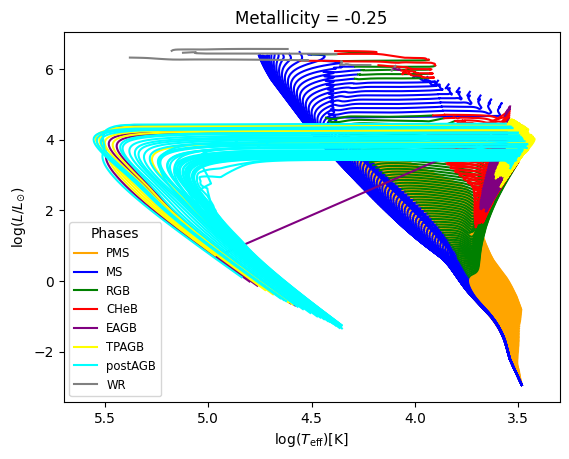

c:\Users\antoi\Code\unif\MA2\thesis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


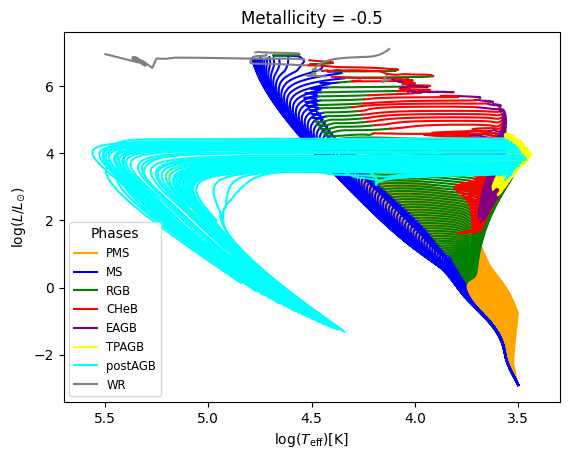

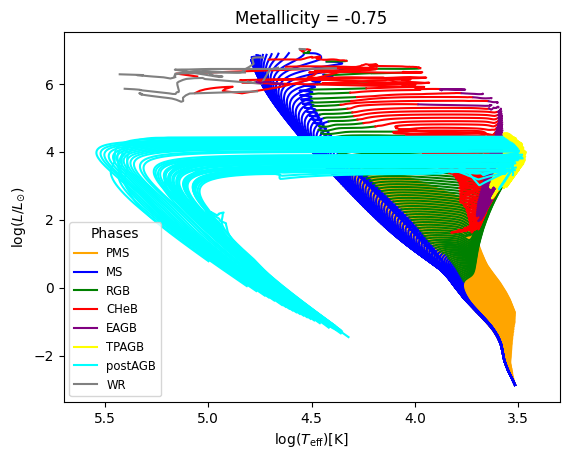

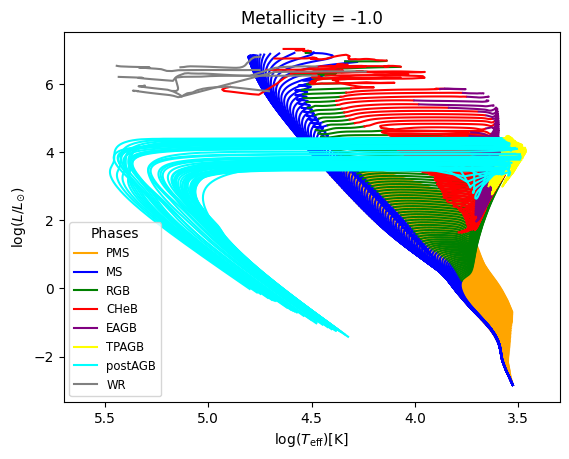

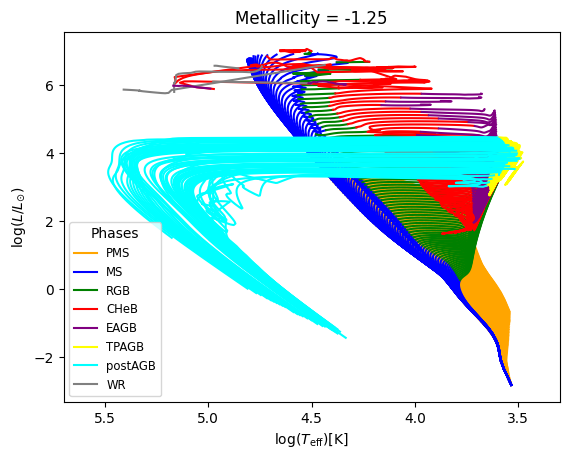

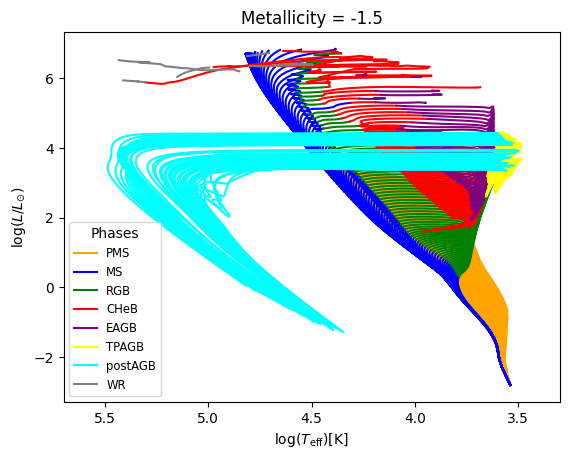

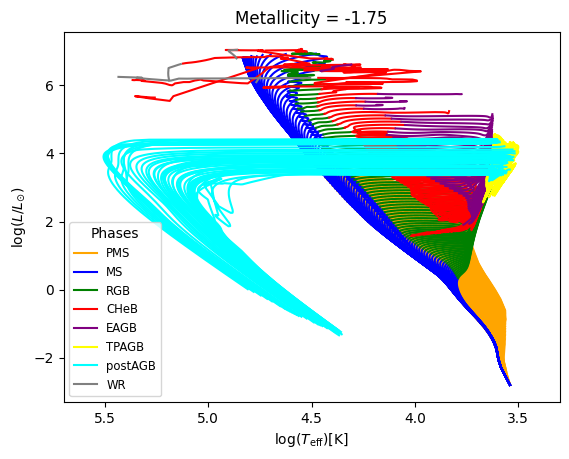

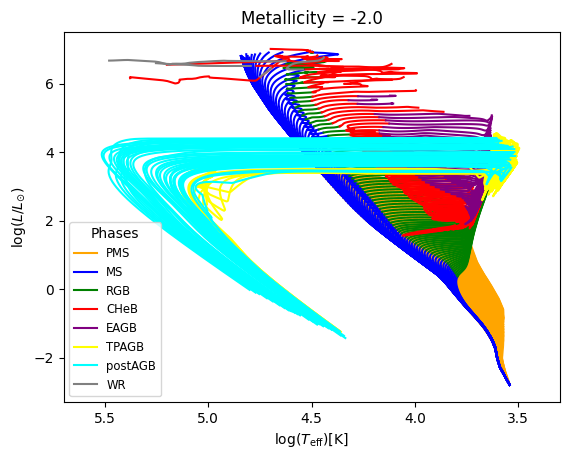

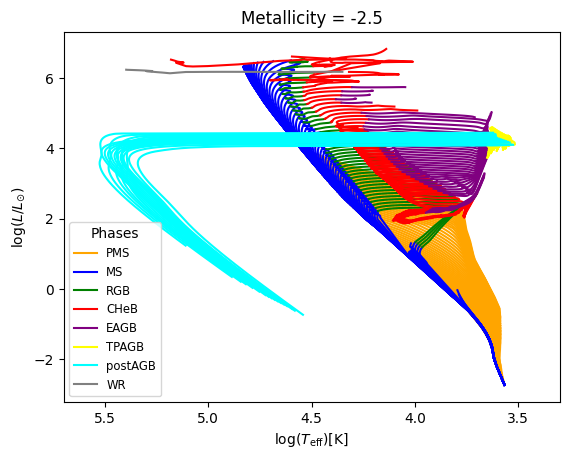

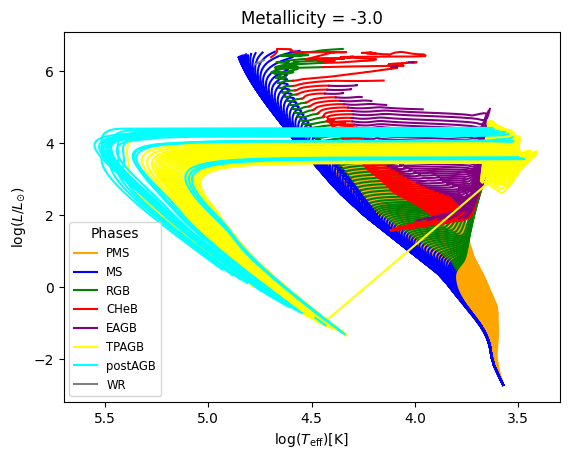

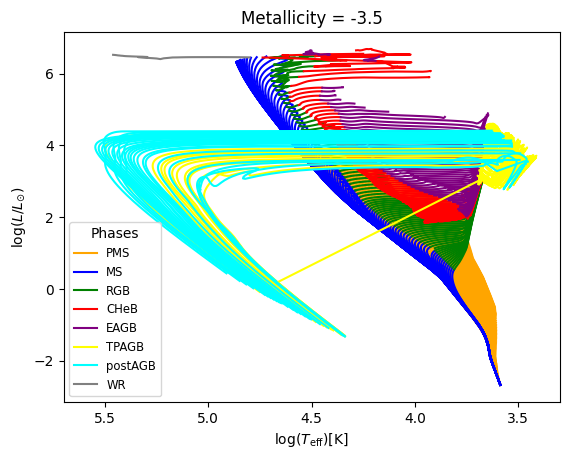

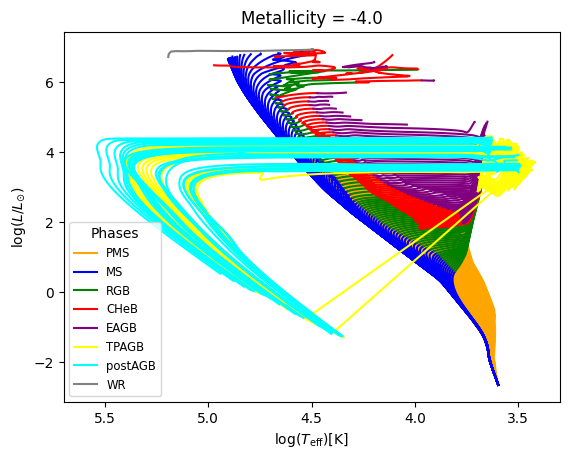

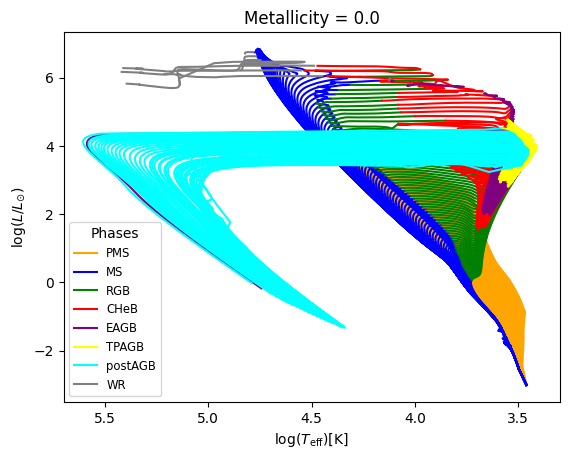

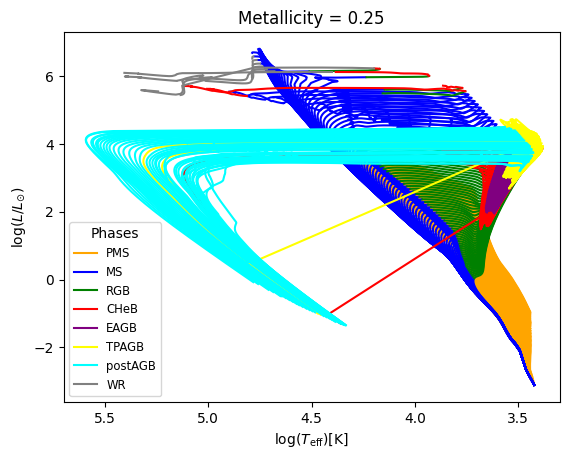

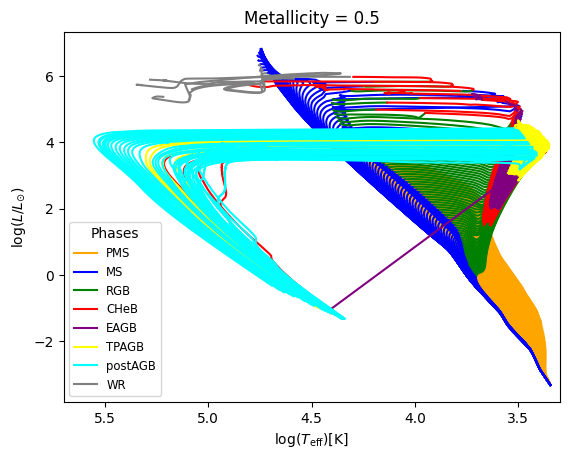

In [ ]:
show_HR(iso_df) # all the data

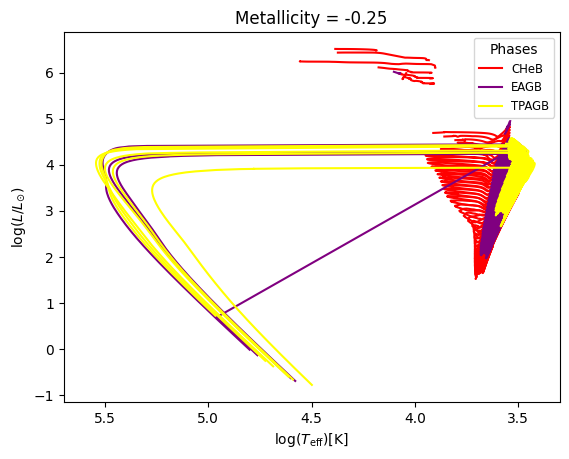

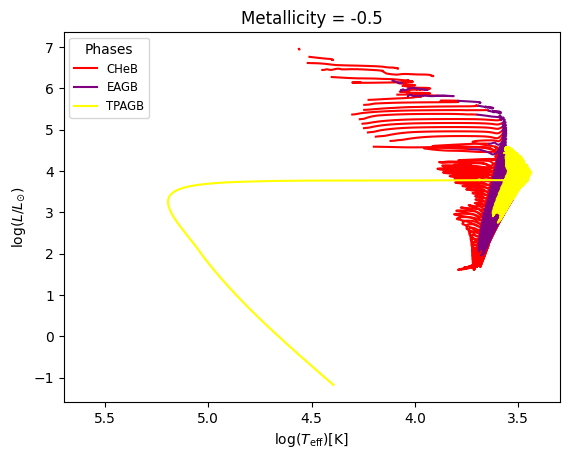

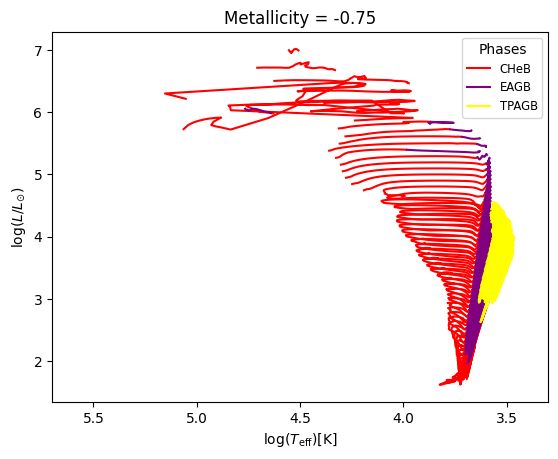

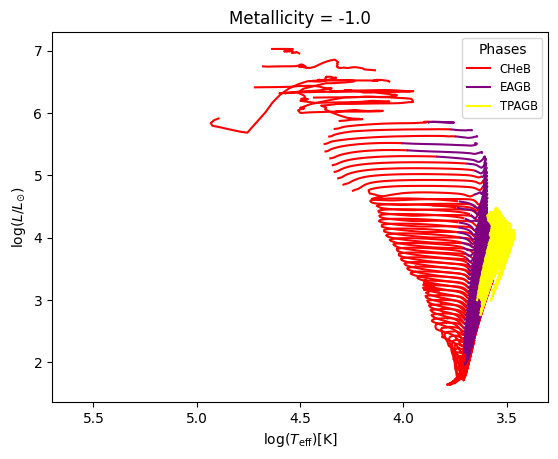

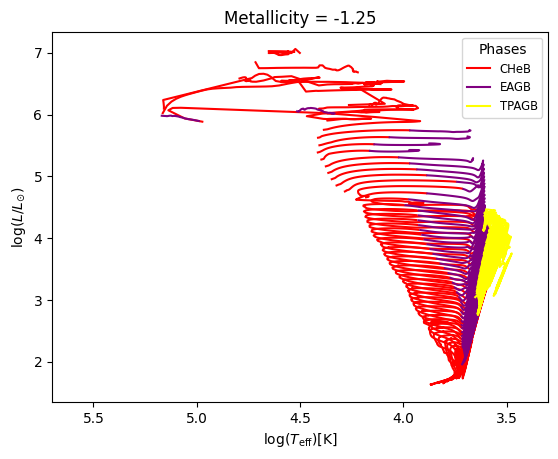

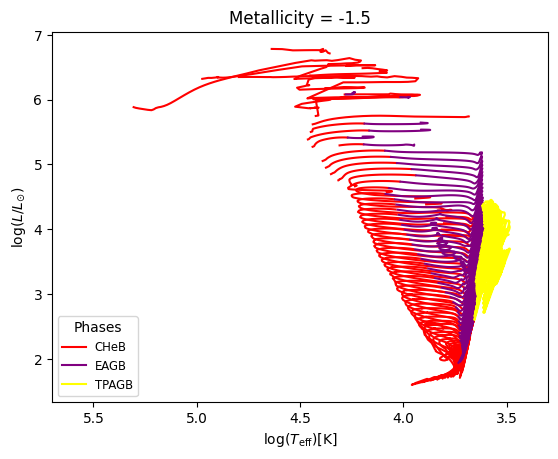

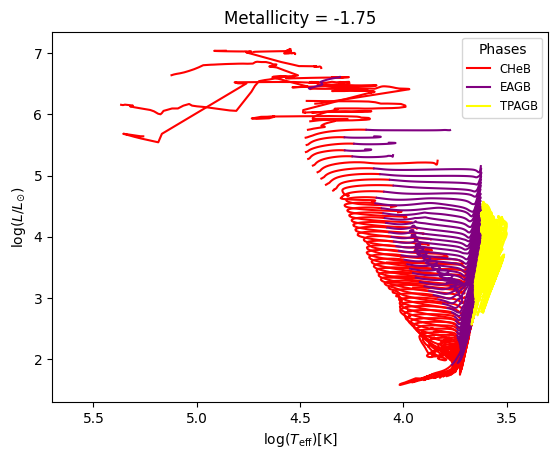

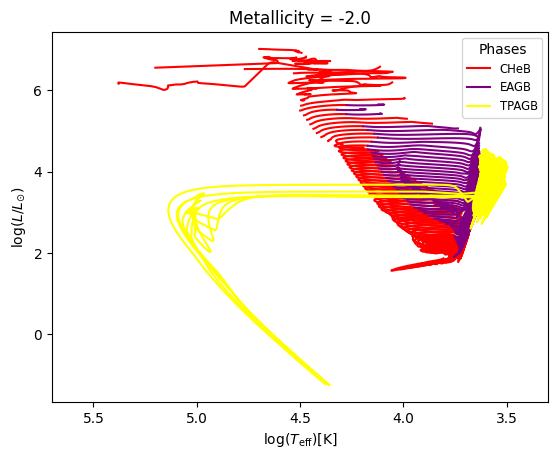

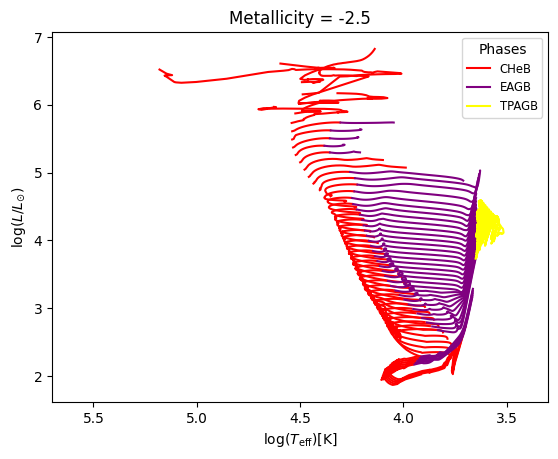

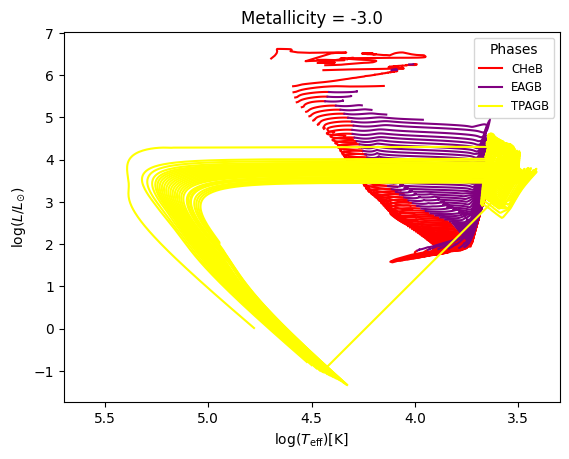

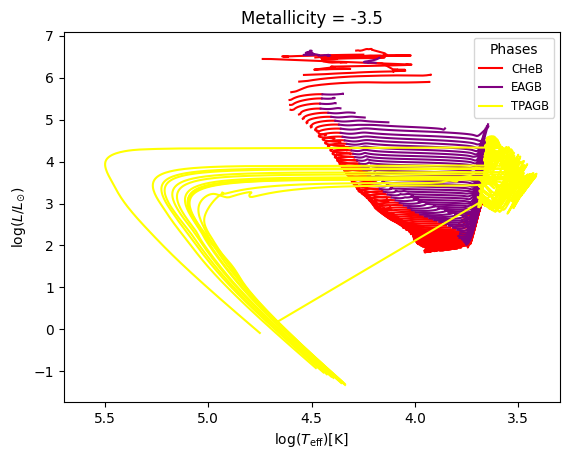

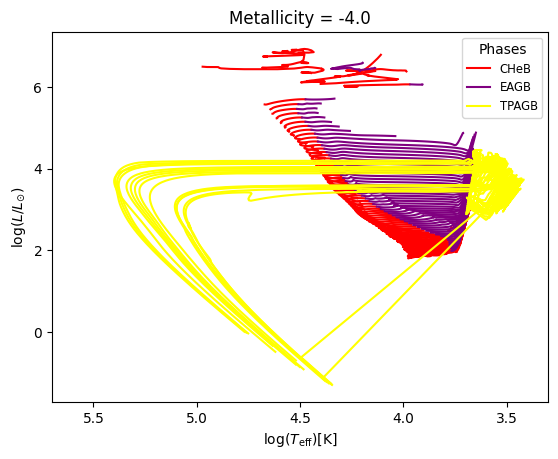

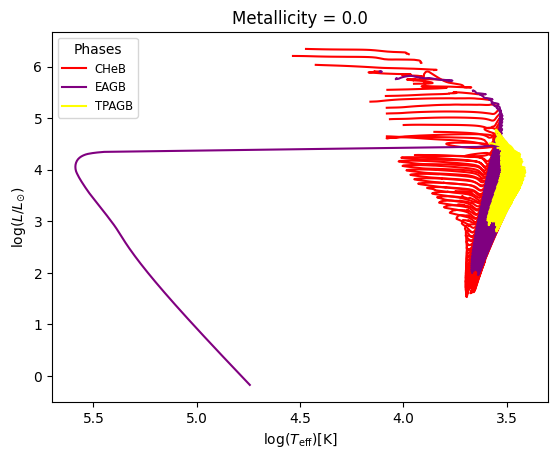

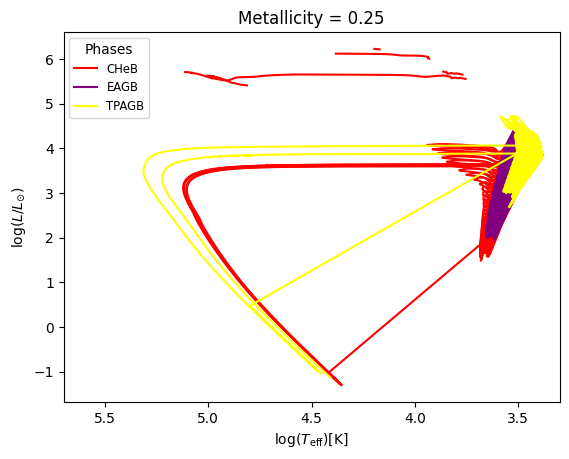

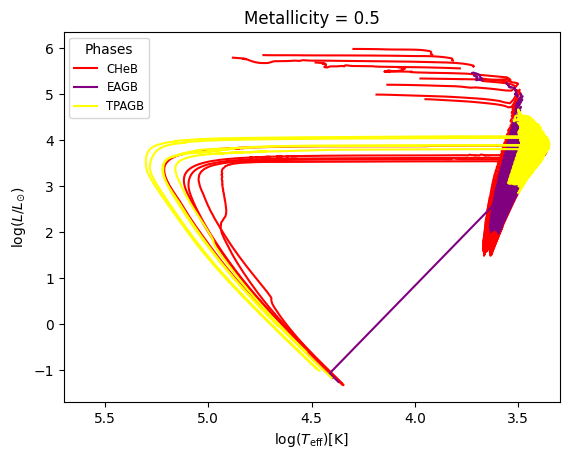

In [ ]:
show_HR(phase_filtered_iso_df) # filter on the phases (phase 3, 4 and 5)

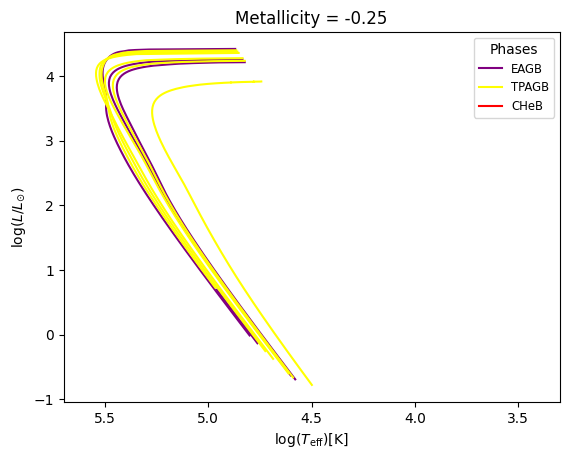

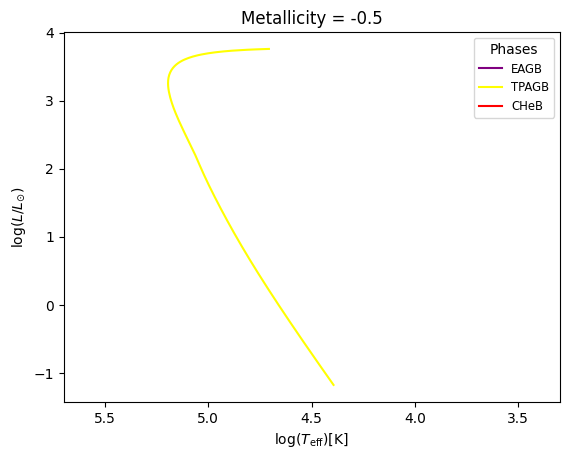

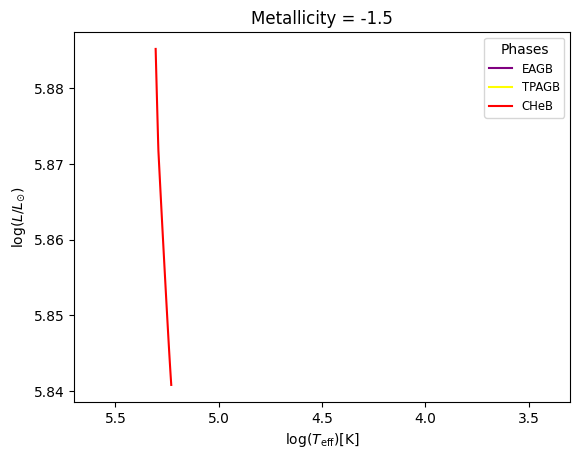

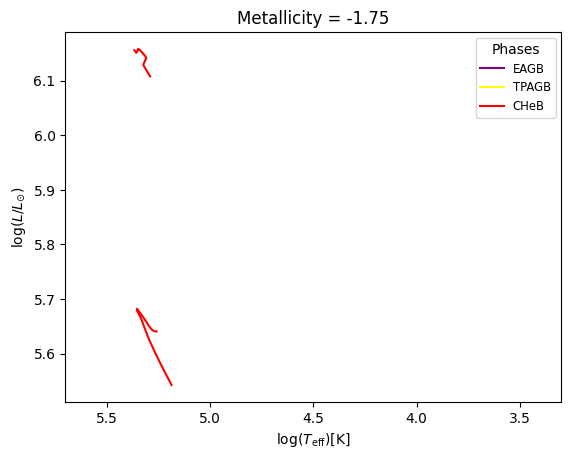

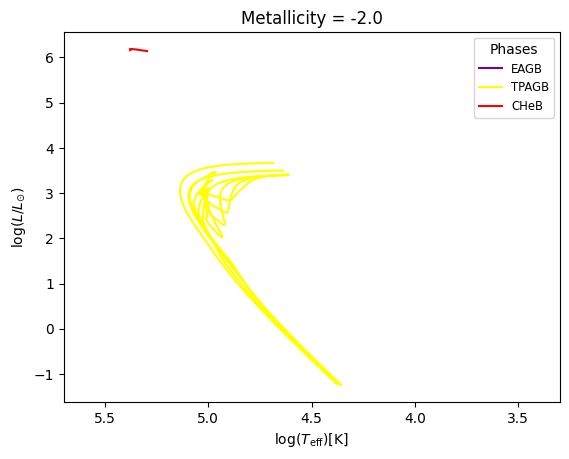

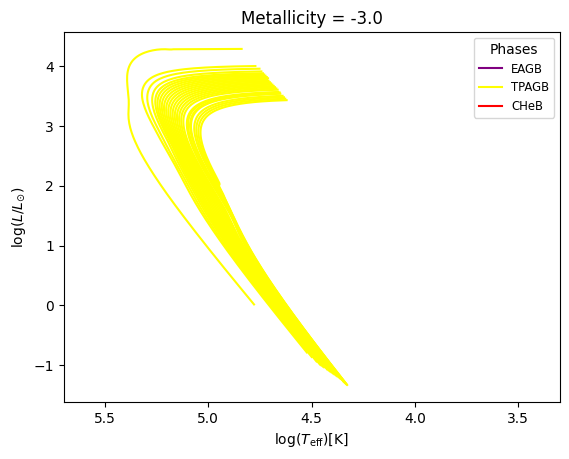

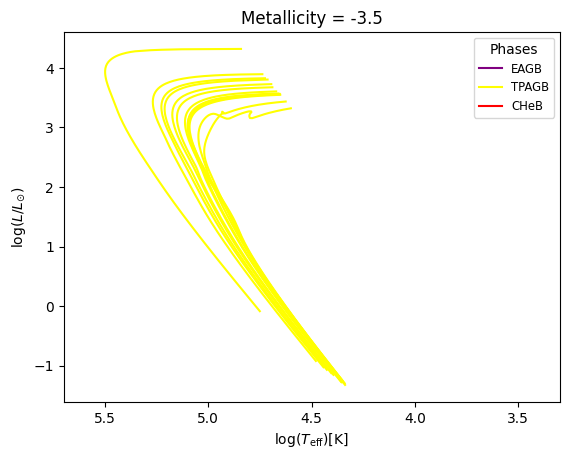

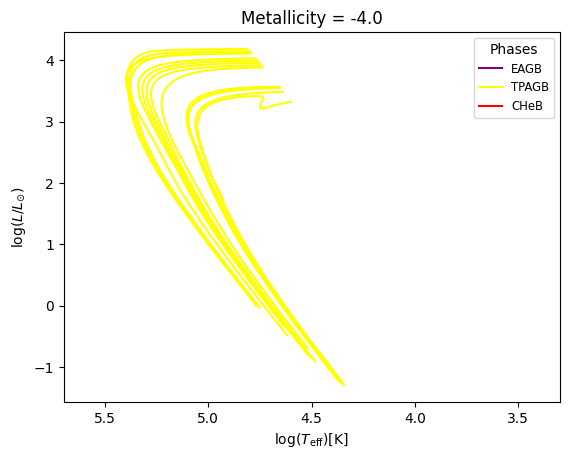

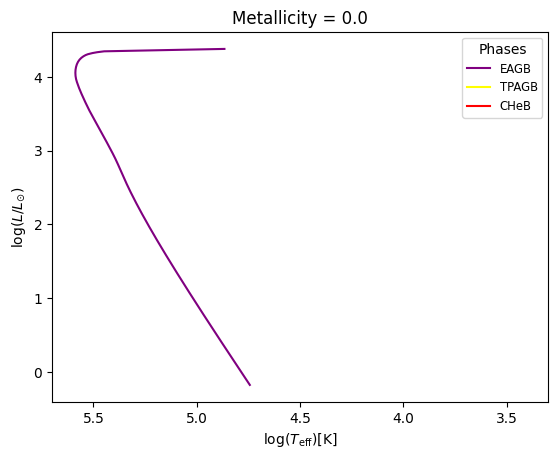

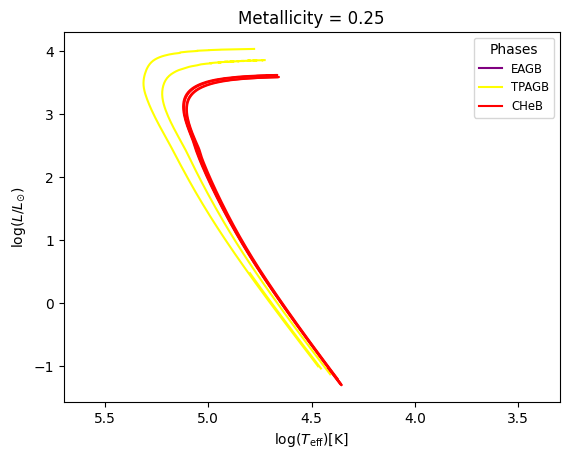

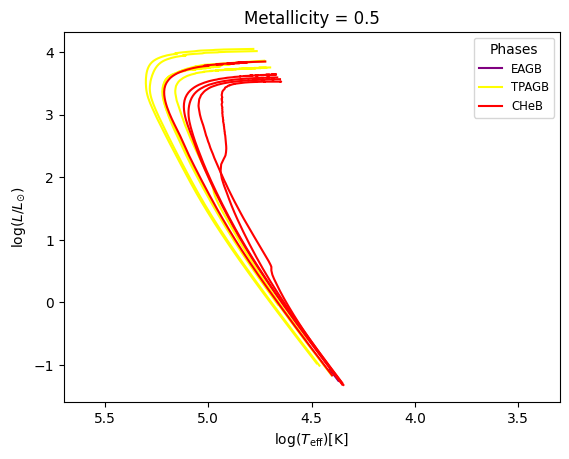

In [161]:
show_HR(phase_log_R_filtered_iso_df)